In [46]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
import matplotlib.pyplot as plt

In [47]:
df = pd.read_csv("/home/bethtian/fintech545/FinTech545_Spring2025/Projects/Project01/problem3.csv")
df.describe()

,x1,x2
count,1000.000000,1000.000000
mean,0.046002,0.099915
std,0.100808,0.142423
min,-0.304570,-0.385778
25%,-0.021692,0.005353
50%,0.049861,0.097981
75%,0.111570,0.194920
max,0.451058,0.592321


# A. Fit a multivariate normal to the data.

In [48]:
mean = np.mean(df, axis = 0)
mean

x1    0.046002
x2    0.099915
dtype: float64

In [49]:
cov = np.cov(df.T)
cov

array([[0.0101622 , 0.00492354],
       [0.00492354, 0.02028441]])

In [50]:
mvn = multivariate_normal(mean = mean, cov = cov)

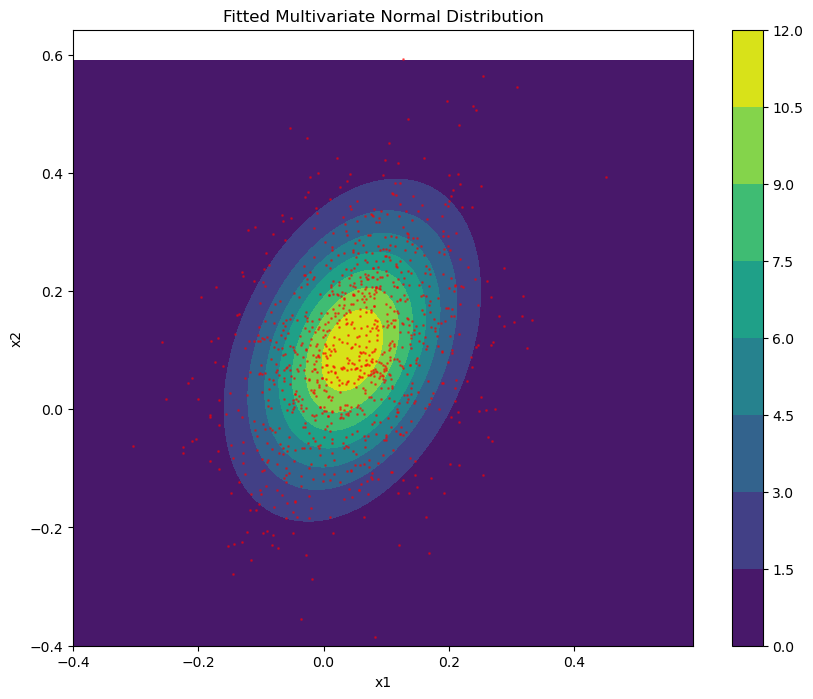

In [51]:
x1_range = np.arange(-0.4, 0.6, 0.01) 
x2_range = np.arange(-0.4, 0.6, 0.01)  
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)  

pos = np.dstack((x1_grid, x2_grid))
rv = mvn.pdf(pos)

plt.figure(figsize=(10, 8))
plt.contourf(x1_range, x2_range, rv)
plt.colorbar()

plt.scatter(df['x1'], df['x2'], c='red', alpha=0.5, s=1)  
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Fitted Multivariate Normal Distribution')
plt.show()

Because there are some eigen values of the covariance matrix less than 0, we cannot prove the matrix is a semi-definite matrix.

#  B. Given that fit, what is the distribution of X2 given X1=0.6. Use the 2 methods described in class.

## B.1 Conditional probability distribution

In [52]:
# According to the question a
mu1 = mean[0]  
mu2 = mean[1]  
sigma11 = cov[0,0]  
sigma12 = cov[0,1]
sigma21 = cov[1,0]  
sigma22 = cov[1,1] 


/tmp/ipykernel_72472/3408521505.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu1 = mean[0]
/tmp/ipykernel_72472/3408521505.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu2 = mean[1]


In [53]:
a = 0.6
conditional_mean = mu2+ sigma21*(0.6 - mu1)/sigma11
conditional_cov = sigma22 - sigma21*sigma21/sigma11

print( f" The conditional expected value is {conditional_mean:.04f}")
print(f" The conditional standard deviation is {conditional_cov:.04f}")

 The conditional expected value is 0.3683
 The conditional standard deviation is 0.0179


In [54]:
x2_range = np.linspace(conditional_mean - 3*np.sqrt(conditional_cov),
                       conditional_mean +3*np.sqrt(conditional_cov) ,100)
conditional_pdf = norm.pdf(x2_range, conditional_mean, np.sqrt(conditional_cov))

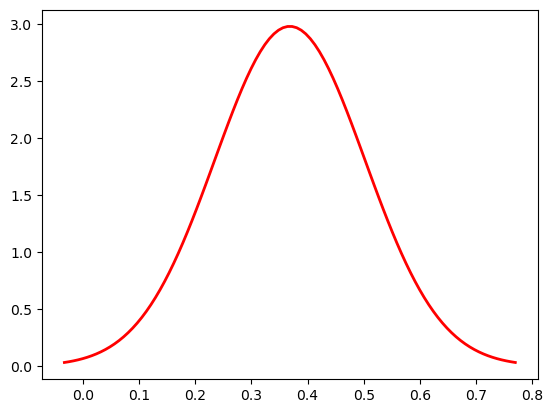

In [55]:
plt.figure()
plt.plot(x2_range, conditional_pdf, 'r-', linewidth=2)
plt.show()

## B.2 OLS

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
X1 = df['x1'].values.reshape(-1, 1)  # reshape为二维数组
X2 = df['x2'].values


In [58]:
model = LinearRegression()
model.fit(X1, X2)

LinearRegression()

In [59]:
beta0 = model.intercept_
beta1 = model.coef_[0]

print("Te result of OLS regression")
print(f"β₀(intercept)) = {beta0:.4f}")
print(f"β₁= {beta1:.4f}")

Te result of OLS regression
β₀(intercept)) = 0.0776
β₁= 0.4845


In [60]:
OLS_mean = beta0 + beta1 * 0.6
y_pred = model.predict(X1)
residuals = X2 - y_pred
OLS_var = np.var(residuals)
OLS_std = np.sqrt(OLS_var)
print(f"\nWhen X1 = 0.6:")
print(f"The conditional expectation is E[X2|X1=0.6] = {OLS_mean:.4f}")
print(f"The conditional standard deviation is = {OLS_var:.4f}")


When X1 = 0.6:
The conditional expectation is E[X2|X1=0.6] = 0.3683
The conditional standard deviation is = 0.0179


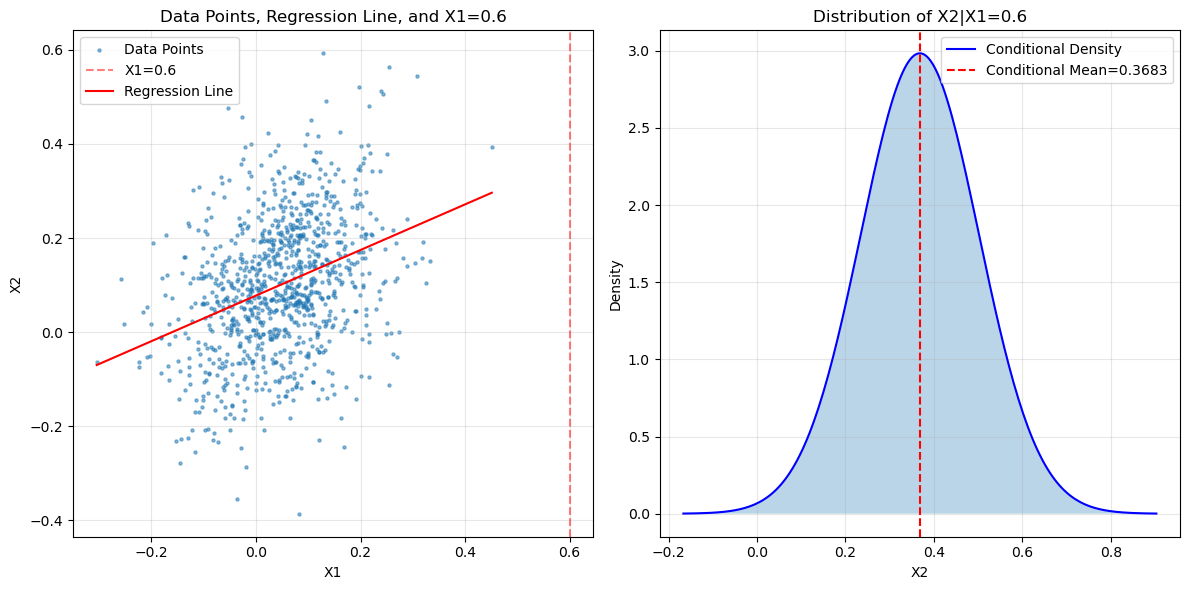

In [61]:
# Create visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X1, X2, alpha=0.5, label='Data Points', s=5)
plt.axvline(x=0.6, color='r', linestyle='--', alpha=0.5, label='X1=0.6')

X1_line = np.linspace(X1.min(), X1.max(), 100).reshape(-1, 1)
X2_pred = model.predict(X1_line)
plt.plot(X1_line, X2_pred, color='red', label='Regression Line')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data Points, Regression Line, and X1=0.6')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
x2_range = np.linspace(OLS_mean - 4*OLS_std, 
                      OLS_mean + 4*OLS_std, 
                      200)
conditional_pdf = norm.pdf(x2_range, OLS_mean, OLS_std)

plt.plot(x2_range, conditional_pdf, 'b-', label='Conditional Density')
plt.fill_between(x2_range, conditional_pdf, alpha=0.3)
plt.axvline(x=OLS_mean, color='r', linestyle='--', 
            label=f'Conditional Mean={OLS_mean:.4f}')

plt.xlabel('X2')
plt.ylabel('Density')
plt.title('Distribution of X2|X1=0.6')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#  C. Given the properties of the Cholesky Root, create a simulation that proves your distribution of X2 | X1=0.6 is correct.

In [62]:
def simulate_conditional_distribution_v2(mean, cov, x1_condition, n_samples=100000):

    L = np.linalg.cholesky(cov)

    Z1 = np.random.standard_normal(n_samples)

    Z1_required = (x1_condition - mean[0]) / L[0, 0]
    Z2 = np.random.standard_normal(n_samples)
    X2_samples = mean[1] + L[1, 0]*Z1_required + L[1, 1]*Z2
    
    return X2_samples

In [63]:
theoretical_mean = mean[1] + cov[0,1]/cov[0,0] * (0.6- mean[0])
theoretical_var = cov[1,1] - cov[0,1]**2/cov[0,0]
print("The results from the Cholesky Root:")
print(f"Theoretical Mean: {theoretical_mean:.4f}")
print(f"Theoretical Variance: {theoretical_var:.4f}")

print("\nThe results from the OLS:")
print(f"The conditional expectation is E[X2|X1=0.6] = {OLS_mean:.4f}")
print(f"The conditional standard deviation is = {OLS_var:.4f}")

print("\nThe results from the conditional probability method:")
print( f"The conditional expected value is {conditional_mean:.04f}")
print(f"The conditional standard deviation is {conditional_cov:.04f}")

The results from the Cholesky Root:
Theoretical Mean: 0.3683
Theoretical Variance: 0.0179

The results from the OLS:
The conditional expectation is E[X2|X1=0.6] = 0.3683
The conditional standard deviation is = 0.0179

The results from the conditional probability method:
The conditional expected value is 0.3683
The conditional standard deviation is 0.0179


/tmp/ipykernel_72472/2810794494.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theoretical_mean = mean[1] + cov[0,1]/cov[0,0] * (0.6- mean[0])
